- [visiualize center loss MNIST](https://github.com/jxgu1016/MNIST_center_loss_pytorch)
### Detail
- paper [here](http://ydwen.github.io/papers/WenECCV16.pdf)
- not just separate but discriminate 
- softmax loss = cross entrophy
- dataset MegaFace also [Labeled Faces in the Wild (LFW), and YouTube Faces (YTF)]
- use 5 landmarks (two eyes, nose and mouth corners) for similarity transformation by this [algorithm](https://arxiv.org/pdf/1604.02878.pdf)
- cropped to 112 × 96

TODO
- pretrain with softmax loss
- MTCNN to face align
- freeze/unfreeze
- 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from exitai.learner import Learner
from exitai.callbacks import Callback
from exitai.losses import CenterLoss
from sklearn.decomposition import PCA
import numpy as np
import random

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class TestDataset(Dataset):
    def __init__(self, dataset, length=10):
        self.dataset = dataset
        self.length = length
    def __getitem__(self, index):
        return random.choice(self.dataset)
    def __len__(self):
        return self.length

In [5]:
transform_train = transforms.Compose([
#                                    transforms.RandomAffine(15, scale=(.9,1.2)), # TODO add me
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train)
dataset_test = datasets.MNIST(root='../../data/', train=False, download=True, transform=transform_test)
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_embedding = nn.Linear(500, 2)
        self.fc_classes = nn.Linear(2, 10)
        
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*4*4)
        output = self.fc_1(output)
        vector_embedding = self.fc_embedding(output)
        output = self.fc_classes(vector_embedding)
        return output, vector_embedding
    
    def name(self):
        return "LeNet"

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.prelu1_2 = nn.PReLU()
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.prelu2_2 = nn.PReLU()
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.prelu3_2 = nn.PReLU()
        self.preluip1 = nn.PReLU()
        self.ip1 = nn.Linear(128*3*3, 2)
        self.ip2 = nn.Linear(2, 10, bias=False)

    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 128*3*3)
        ip1 = self.preluip1(self.ip1(x))
        ip2 = self.ip2(ip1)
        return ip2, ip1

In [8]:
def visualize(vectors_embedding, target, epoch):
    plt.ion()
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    plt.clf()
    for i in range(10):
        plt.plot(vectors_embedding[target == i, 0], vectors_embedding[target == i, 1], '.', c=c[i])
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc = 'upper right')
#     plt.xlim(xmin=-80,xmax=80)
#     plt.ylim(ymin=-80,ymax=80)
    plt.text(-7.8,7.3,"epoch=%d" % epoch)
#     plt.savefig('./images/epoch=%d.jpg' % epoch)
    plt.draw()
    plt.pause(0.001)

In [9]:
class Plottracker(Callback):
    def __init__(self):
        self.target = []
        self.vectors_embedding = []
        self.epoch = 0
        
    def add(self, target, vector_embedding):
        self.target.append((target))
        self.vectors_embedding.append((vector_embedding))
        
    def on_epoch_end(self, phase, num_data):
        vectors_embedding = torch.cat(self.vectors_embedding, 0)
        targets = torch.cat(self.target, 0)
        self.epoch += 1
        visualize(vectors_embedding.data.cpu().numpy(), targets.data.cpu().numpy(), self.epoch)

In [10]:
plottracker = Plottracker()
center_loss = CenterLoss(10, 2).to(device)
def model_loss_func(input_data, model, phase):
    input, target = input_data
    output, vector_embedding = model(input)
    plottracker.add(target, vector_embedding)
    
    # Loss
    loss = F.cross_entropy(output, target) #+ 0.01*center_loss(target, vector_embedding)
    return output, loss

In [11]:
###### Learning Rate Finder ######

# model = LeNet()
# learner = Learner(data_loader_train, data_loader_test, model)
# learner.lr_find(model_loss_func, 1e-7, 0.3)

In [12]:
class CenterLossOptimHook(Callback):
    def __init__(self):
        self.optim = torch.optim.SGD(center_loss.parameters(), lr=0.05)
    def on_batch_end(self, phase, input_data, output, loss):
        if phase is 'train':
            self.optim.step()
            self.optim.zero_grad()
            

---- epoch:0 ------
   [train] Average loss: 1.7969, acc: 10.45%


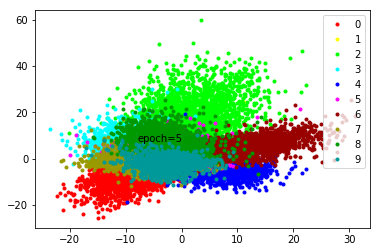

---- epoch:1 ------
   [train] Average loss: 1.1739, acc: 44.44%


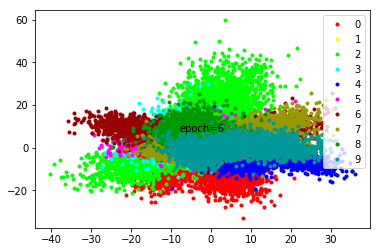

---- epoch:2 ------
   [train] Average loss: 0.4373, acc: 83.38%


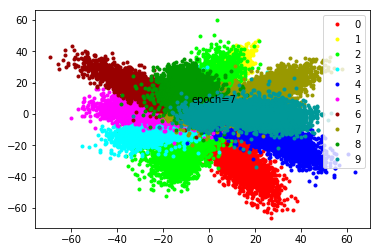

---- epoch:3 ------
   [train] Average loss: 0.2475, acc: 92.03%


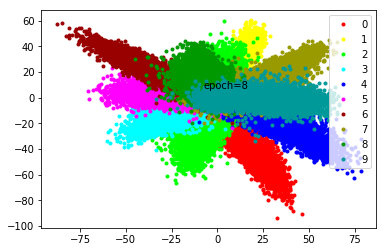

---- epoch:4 ------
   [train] Average loss: 0.1742, acc: 94.29%


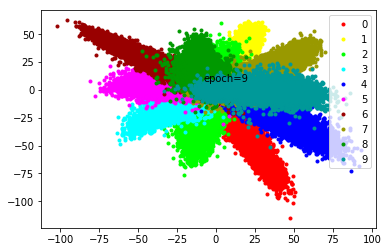

---- epoch:5 ------
   [train] Average loss: 0.1290, acc: 95.82%


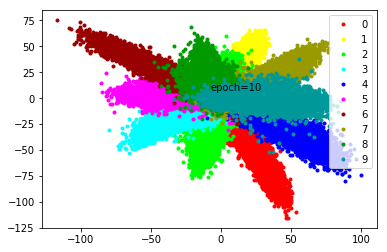

---- epoch:6 ------
   [train] Average loss: 0.1012, acc: 96.67%


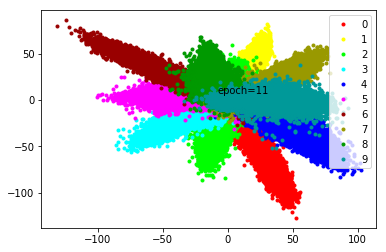

---- epoch:7 ------
   [train] Average loss: 0.0829, acc: 97.19%


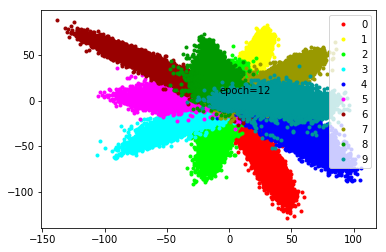

---- epoch:8 ------
   [train] Average loss: 0.0670, acc: 97.53%


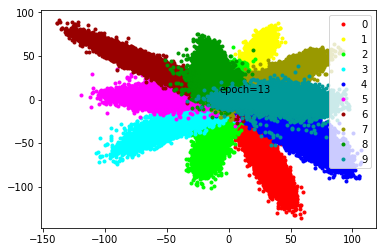

---- epoch:9 ------
   [train] Average loss: 0.0550, acc: 97.97%


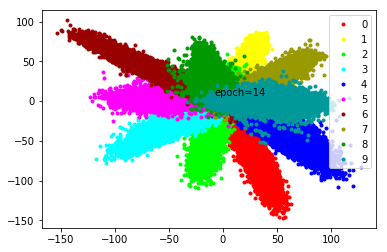

---- epoch:10 ------
   [train] Average loss: 0.0447, acc: 98.39%


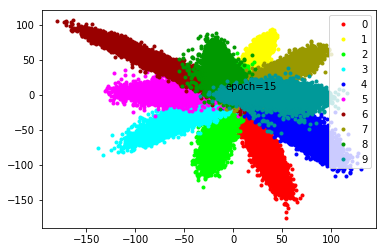

---- epoch:11 ------
   [train] Average loss: 0.0394, acc: 98.51%


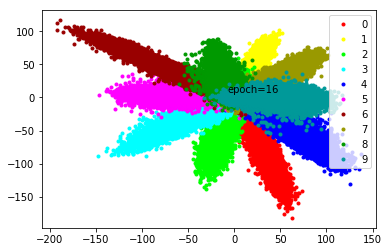

---- epoch:12 ------
   [train] Average loss: 0.0324, acc: 98.70%


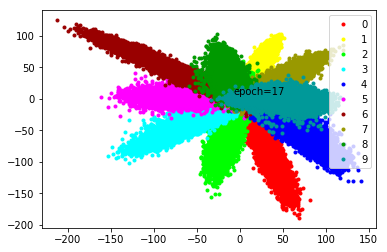

---- epoch:13 ------
   [train] Average loss: 0.0271, acc: 98.93%


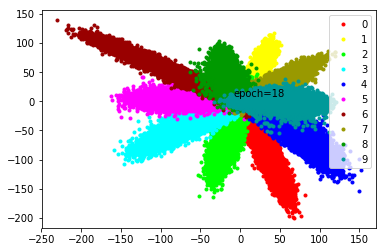

---- epoch:14 ------
   [train] Average loss: 0.0217, acc: 99.16%


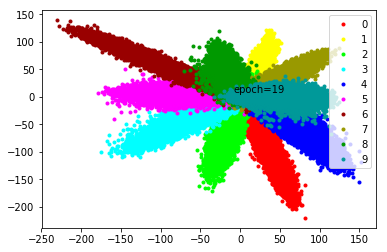

---- epoch:15 ------
   [train] Average loss: 0.0230, acc: 99.08%


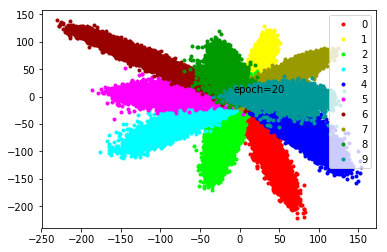

---- epoch:16 ------
   [train] Average loss: 0.0148, acc: 99.43%


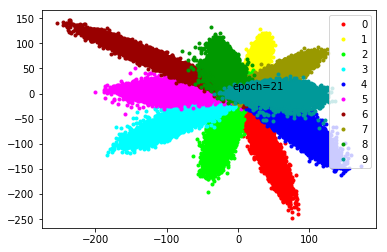

---- epoch:17 ------
   [train] Average loss: 0.0149, acc: 99.44%


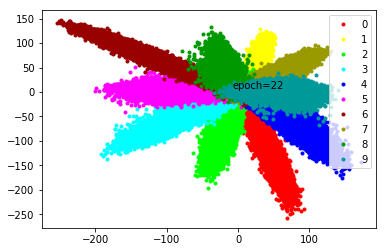

---- epoch:18 ------
   [train] Average loss: 0.0139, acc: 99.44%


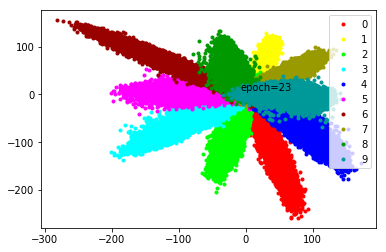

---- epoch:19 ------
   [train] Average loss: 0.0132, acc: 99.46%


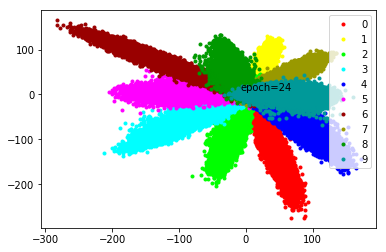

---- epoch:20 ------
   [train] Average loss: 0.0069, acc: 99.73%


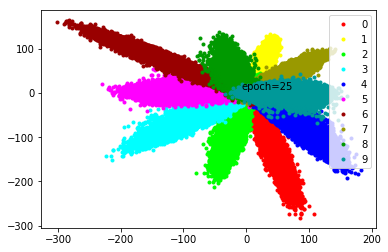

---- epoch:21 ------
   [train] Average loss: 0.0045, acc: 99.83%


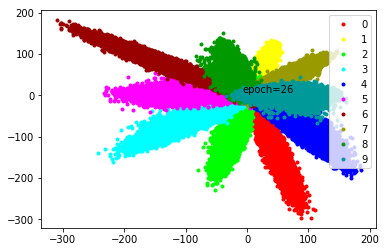

---- epoch:22 ------
   [train] Average loss: 0.0022, acc: 99.94%


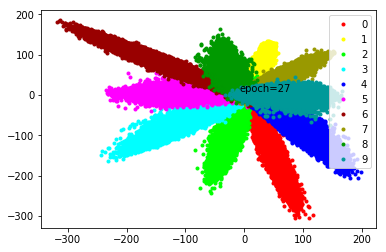

---- epoch:23 ------
   [train] Average loss: 0.0018, acc: 99.96%


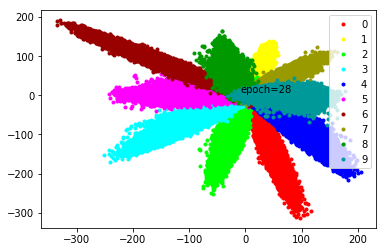

---- epoch:24 ------
   [train] Average loss: 0.0011, acc: 99.98%


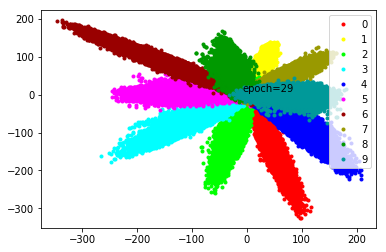

---- epoch:25 ------
   [train] Average loss: 0.0008, acc: 99.99%


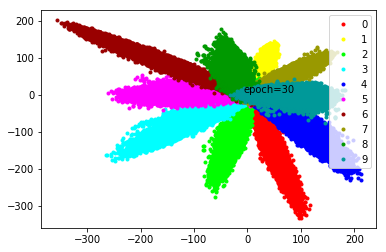

---- epoch:26 ------
   [train] Average loss: 0.0006, acc: 100.00%


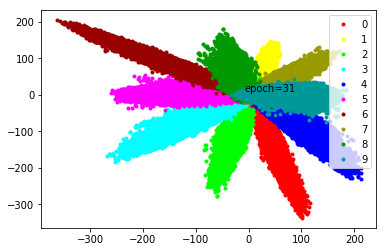

---- epoch:27 ------
   [train] Average loss: 0.0005, acc: 100.00%


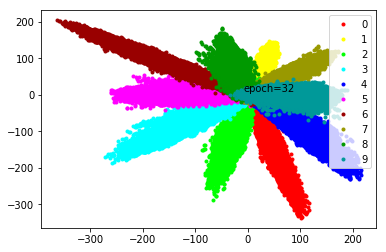

---- epoch:28 ------
   [train] Average loss: 0.0004, acc: 100.00%


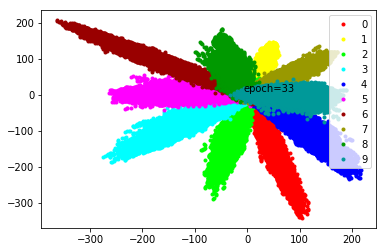

---- epoch:29 ------
   [train] Average loss: 0.0004, acc: 100.00%


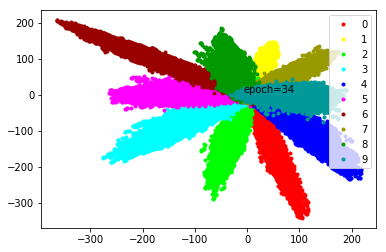

---- epoch:30 ------
   [train] Average loss: 0.0004, acc: 100.00%


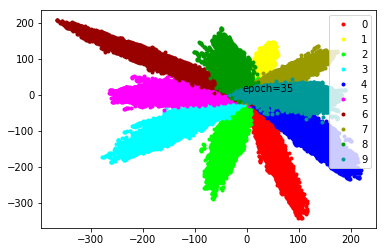

---- epoch:31 ------
   [train] Average loss: 0.0004, acc: 100.00%


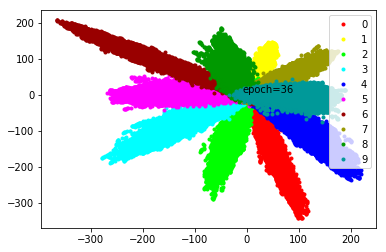

---- epoch:32 ------
   [train] Average loss: 0.0004, acc: 100.00%


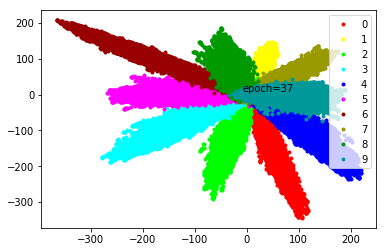

---- epoch:33 ------
   [train] Average loss: 0.0004, acc: 100.00%


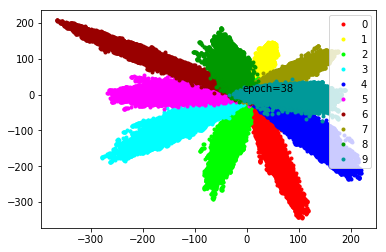

---- epoch:34 ------
   [train] Average loss: 0.0004, acc: 100.00%


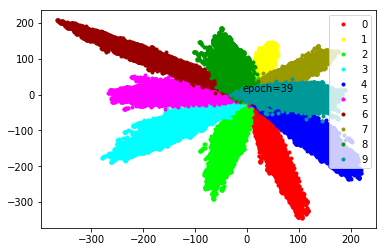

---- epoch:35 ------
   [train] Average loss: 0.0004, acc: 100.00%


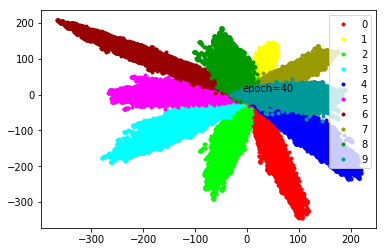

---- epoch:36 ------
   [train] Average loss: 0.0004, acc: 100.00%


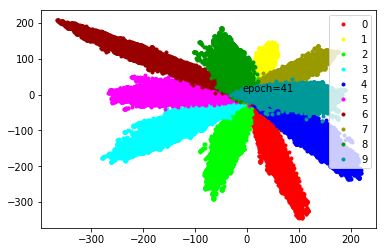

---- epoch:37 ------
   [train] Average loss: 0.0004, acc: 100.00%


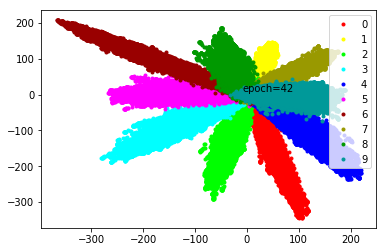

---- epoch:38 ------
   [train] Average loss: 0.0004, acc: 100.00%


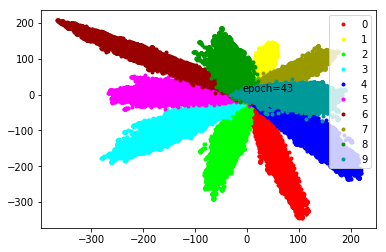

---- epoch:39 ------
   [train] Average loss: 0.0004, acc: 100.00%


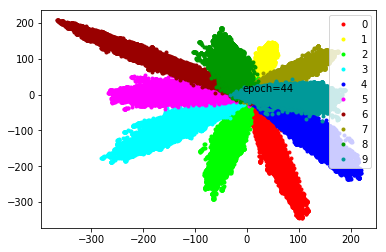

---- epoch:40 ------
   [train] Average loss: 0.0004, acc: 100.00%


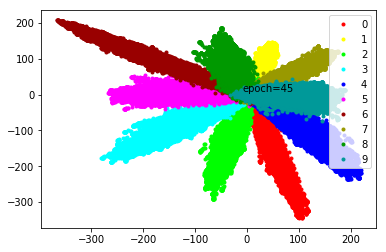

---- epoch:41 ------
   [train] Average loss: 0.0004, acc: 100.00%


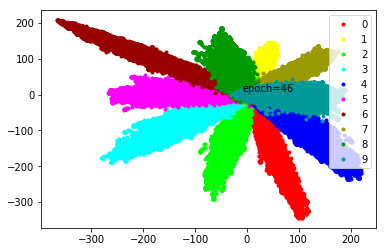

---- epoch:42 ------
   [train] Average loss: 0.0004, acc: 100.00%


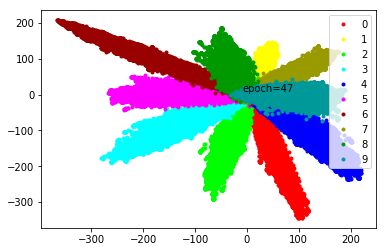

---- epoch:43 ------
   [train] Average loss: 0.0004, acc: 100.00%


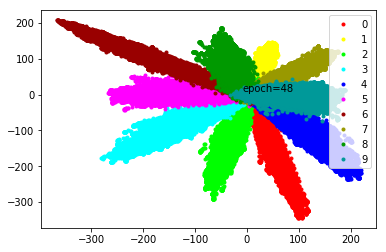

---- epoch:44 ------
   [train] Average loss: 0.0004, acc: 100.00%


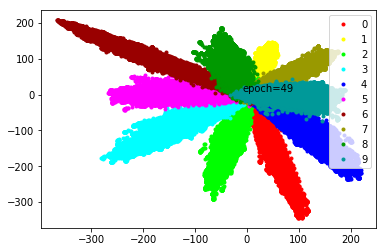

---- epoch:45 ------
   [train] Average loss: 0.0004, acc: 100.00%


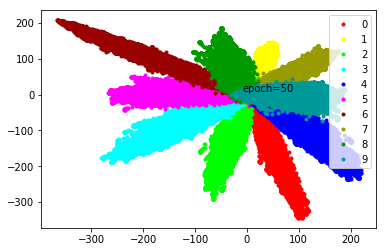

---- epoch:46 ------
   [train] Average loss: 0.0004, acc: 100.00%


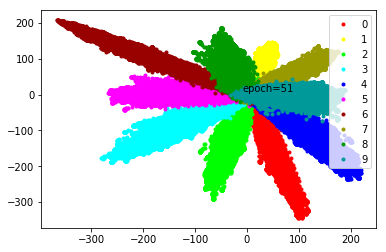

---- epoch:47 ------
   [train] Average loss: 0.0004, acc: 100.00%


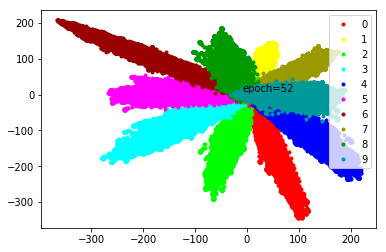

---- epoch:48 ------


In [ ]:
model = Net() #LeNet()
learner = Learner(model, data_loader_train)
learner.fit(model_loss_func, 0.002, num_epochs=100, cycle=None, callbacks=[plottracker, CenterLossOptimHook()])

In [ ]:
a = torch.tensor([[1,2],[3,4],[5,6]])
a.new_empty((2,3)).fill_(100)